# AMATERASU tutorial

In this notebook, how to run AMATERASU, this time for 1D spectra.
I had the spectra in a folder, so I use a customized function to fetch them (in SpecFunc.py).

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gzip
import pickle
import pandas as pd

import specutils
import scipy
import astropy

The indice table contains 9 predefined spectral lines predefined: 3 of K I, 2 of Ti I, 2 of Al I, 2 of Mn I and 1 of Fe I. The suffix "a" or "b" only serves to identify the lines more easily. "ln_win" and "interp_win" are the maximum central bandpass and interpolation/continuum windows, respectively. These are merely suggestions and may be changed at will.

In [2]:
ind_table = pd.read_csv("../ind_table.csv")
ind_table

,ln_id,ln_ctr,ln_win,interp_win
0,KI_a,11772.862,3,9
1,KI_b,12435.647,4,12
2,KI_c,12525.544,4,12
3,AlI_a,13127.011,5,15
4,AlI_b,13154.345,5,15
5,FeI,11693.408,4,12
6,MnI,12903.289,4,12
7,TiI_a,10498.989,3,9
8,TiI_b,12825.181,3,9


Let's run AMATERASU in NIRPS observations of Proxima Centauri. The way you extract the data is irrelevant, as long the final arrays to feed the tool have the dimensions printed below and are RV corrected. We also note that the data we used are telluric corrected.

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
parent_dir = "/home/telmo/Thesis/AMATERASU/AMATERASU-main/"  #adjust this path as needed
sys.path.append(parent_dir)


from amaterasu.AMATERASU import AMATERASU
from amaterasu.time_series_clean import time_series_clean

from SpecFunc import SpecFunc
SpecFunc = SpecFunc()

In [7]:
#gather spectra
_, files = SpecFunc._gather_spectra(star_name="GJ551", instrument="NIRPS",type="1d")

spectra_observations = []
bjd_observations = np.zeros((len(files)))

fwhm_array = np.zeros((len(files)))
fwhm_err_array = np.zeros((len(files)))

for i, file in enumerate(files):

    spectrum_raw, header_raw = SpecFunc._Read(file, mode="vac")
    spectrum, header = SpecFunc._RV_correction(spectrum_raw, header_raw)

    spectra_observations.append([spectrum["wave"], spectrum["flux"], spectrum["flux_error"]])

    bjd_observations[i] = header["bjd"]

    fwhm_array[i] = header["fwhm"]
    fwhm_err_array[i] = header["fwhm_err"]

spectra_observations = np.array(spectra_observations, dtype=object) 

In [8]:
print("CCF FWHM array shape: ",fwhm_array.shape)
print("BJD array shape: ",bjd_observations.shape)
print("spectra observations array shape: ",spectra_observations.shape)

CCF FWHM array shape:  (137,)
BJD array shape:  (137,)
spectra observations array shape:  (137, 3, 221629)


As a test, let's first extract the period of CCF FWHM, known to closely follow stellar activity.

In [9]:
df_fwhm = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array,"fwhm_error":fwhm_err_array})
df_fwhm_clean = time_series_clean(df_fwhm, ["fwhm"], ["fwhm_error"], sigma=3, sigma_clip=True, bin_night=True).df

star = "Proxima"
ind = "fwhm"
bandpasses = ["fwhm"]
fap_treshold = 0.001

gls_df, all_gls_df = AMATERASU._compute_gls(star,ind,bandpasses,None,fap_treshold,df_fwhm_clean,bandpasses,
                                            False,output="standard",
                                            spec_lines_folder=None)

gls_df

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


,bandpass,period,FAP
0,fwhm,"[78.93636782303244, 99.64282344650668, 41.2838...","[6.3263007668744775e-12, 2.4318812029013097e-0..."


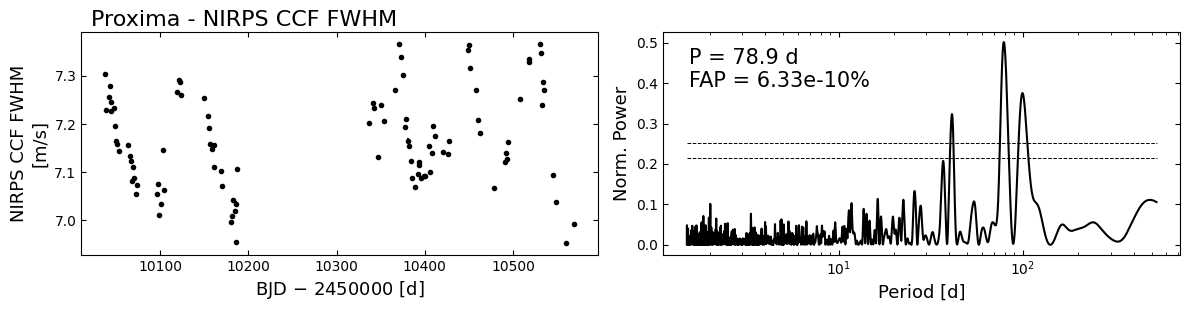

In [10]:
fig, axes = plt.subplots(ncols=2,figsize=(12, 3), sharex="col")

col = "fwhm"
results = all_gls_df.iloc[0].to_dict()

axes[0].errorbar(df_fwhm_clean["BJD"] - 2450000, df_fwhm_clean[col], df_fwhm_clean[col+"_error"], fmt="k.")

axes[0].set_ylabel(f"NIRPS CCF FWHM\n[m/s]", fontsize=13)
axes[0].set_xlabel("BJD $-$ 2450000 [d]", fontsize=13)
axes[0].tick_params(axis="both", direction="in", top=True, right=True, which='both')

axes[1].semilogx(results["period"], results["power"], "k-")
axes[1].plot([min(results["period"]), max(results["period"])], [results["fap01_power"]] * 2,"--",color="black",lw=0.7)
axes[1].plot([min(results["period"]), max(results["period"])], [results["fap1_power"]] * 2,"--",color="black",lw=0.7)

axes[1].set_ylabel("Norm. Power", fontsize=13)
axes[1].set_xlabel("Period [d]", fontsize=13)
axes[1].tick_params(axis="both", direction="in", top=True, right=True, which='both')
axes[1].text(0.05, 0.93,f"P = {np.around(results['period_best'], 1)} d \nFAP = {results['fap_best']*100:.2e}%",fontsize=15,transform=axes[1].transAxes,verticalalignment="top")

fig.text(0.08, 0.97, f"{star} - NIRPS CCF FWHM", fontsize=16)

fig.subplots_adjust(hspace=0)
plt.tight_layout()
plt.show()

We will test two spectral lines: K I (b) and (c). The input periods will be value close to the literature rotation period with an uncertainty, the tolerance will be 10 d and the FAP threshold for detection is 0.1%.

For the correlations, we will test with the CCF FWHM of NIRPS observations, using a treshold of $\rho_S \geq 0.4$ and p-val of 0.1% for the absolute correlation to be considered "strong".

Below all input for AMATERASU is shown.

In [11]:
#options for AMATERASU

star = "Proxima" #star name

data = [bjd_observations, spectra_observations]

run_gls = True
#periods that will be tested. two of them close to the real rotation period of Proxima and one close to the orbital period of Proxima b
period_test = [[80,5],[85,8],[11,2]]
ptol = [10,10,2] #10 days of tolerance for higher periods, 2 for the lower
fap_treshold = 0.001
plot_gls=True 
gls_options = [run_gls, period_test, ptol, fap_treshold, plot_gls]


run_correlation=True
df_fwhm = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array,"fwhm_err":fwhm_err_array})
cols_input = ["fwhm"]
cols_err_input = ["fwhm_err"]
abs_corr_threshold=0.4
pval_threshold=0.001
correlation_options = [run_correlation, df_fwhm, cols_input, cols_err_input, abs_corr_threshold, pval_threshold]

#spectral lines to be tested:

indices = ["KI_c"]

indice_info = {
                "KI_b":{'ln_ctr':12435.647},
                "KI_c":{'ln_ctr':12525.544},
                }

Now let's run the "standard" version of AMATERASU, the simplest. We give the star name, data, lines names and centers, options for GLSPs and correlations and the folder to save.

AMATERASU instance created for Proxima


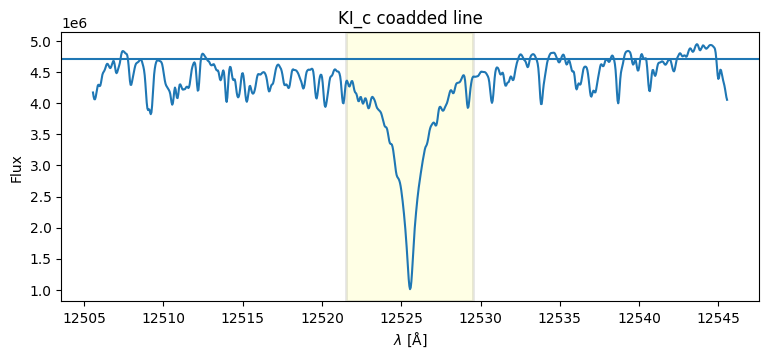

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 8.0
Interpolation window: 40.0
--------------------------------------------------------------------------------


100%|██████████| 137/137 [01:17<00:00,  1.76it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 80/80 [00:11<00:00,  6.95it/s]


Bandpass with period near to input and lowest FAP: 4.0
Period [d]: 79.56264273436763
FAP: 3.04e-19
Number of bandpasses that detect period near to input: 79
    bandpass                period                        FAP input_period
0        0.1  (79.90073667446276,)   (6.041178274495205e-14,)     [80, 85]
1        0.2  (80.58561863369667,)   (7.742953738513047e-12,)     [80, 85]
2        0.3   (82.1703758369097,)   (7.958352092097601e-06,)     [80, 85]
3        0.5  (77.23411900087751,)  (0.00016360927951424757,)     [80, 85]
4        0.6  (77.99500042013943,)   (2.098020736588748e-08,)     [80, 85]
..       ...                   ...                        ...          ...
74       7.6  (79.56264273436763,)   (4.669058461865136e-11,)     [80, 85]
75       7.7  (79.56264273436763,)   (7.450103271959034e-11,)     [80, 85]
76       7.8  (79.56264273436763,)  (1.0554211603706241e-10,)     [80, 85]
77       7.9  (79.56264273436763,)  (1.0575367600699074e-10,)     [80, 85]
78       8.0  (79.

In [9]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options, 
                      output="standard", 
                      folder_path=f"tutorial_results_1d/", 
                      plot_line=True)

As we can see, both lines are able to detect Proxima's rotation period quite nicely in the majority of central bandpasses, as well as strong correlation with the CCF FWHM of NIRPS.

Finally, let's test AMATERASU with the "full" output.

AMATERASU instance created for Proxima


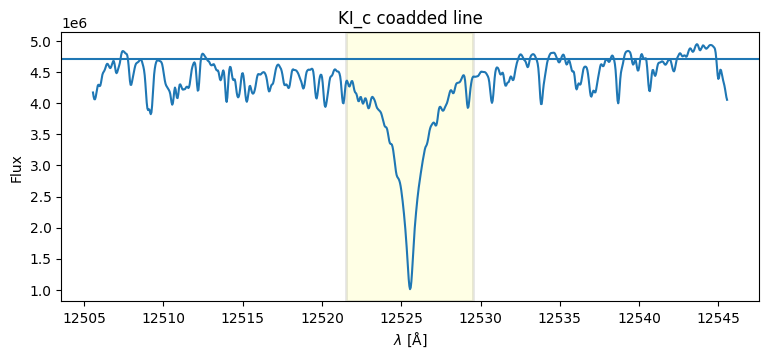

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 8.0
Interpolation window: 40.0
--------------------------------------------------------------------------------


100%|██████████| 137/137 [01:12<00:00,  1.89it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 80/80 [03:04<00:00,  2.31s/it]


Bandpass with period near to input and lowest FAP: 4.0
Period [d]: 79.56264273436763
FAP: 3.04e-19
Number of bandpasses that detect period near to input: 79
    bandpass                period                        FAP input_period
0        0.1  (79.90073667446276,)   (6.041178274495205e-14,)     [80, 85]
1        0.2  (80.58561863369667,)   (7.742953738513047e-12,)     [80, 85]
2        0.3   (82.1703758369097,)   (7.958352092097601e-06,)     [80, 85]
3        0.5  (77.23411900087751,)  (0.00016360927951424757,)     [80, 85]
4        0.6  (77.99500042013943,)   (2.098020736588748e-08,)     [80, 85]
..       ...                   ...                        ...          ...
74       7.6  (79.56264273436763,)   (4.669058461865136e-11,)     [80, 85]
75       7.7  (79.56264273436763,)   (7.450103271959034e-11,)     [80, 85]
76       7.8  (79.56264273436763,)  (1.0554211603706241e-10,)     [80, 85]
77       7.9  (79.56264273436763,)  (1.0575367600699074e-10,)     [80, 85]
78       8.0  (79.

: 

In [ ]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options,
                    output="full", 
                    plot_line=True, folder_path="tutorial_results_1d_full")

As a final exercise, let's plot the period with lowest FAP for each central bandpass of each line in function of the central bandpass.

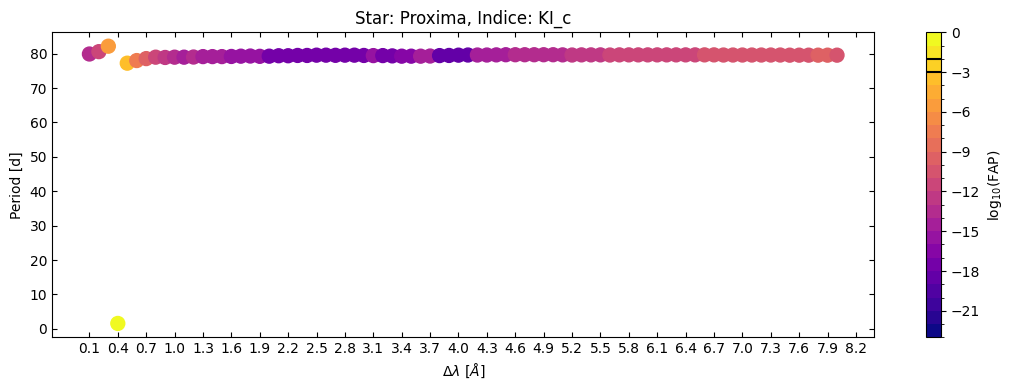

In [12]:
import ast
import matplotlib.colors as mcolors 

def periods_bandpass_plot(star, indice):

    df_gls = pd.read_csv(f"tutorial_results_1d_full/{star}/{indice}/periods_full_{star}_{indice}.csv")

    cmap = plt.get_cmap("plasma")
    log_FAP_min, log_FAP_max = 0, -23 #-23 is an arbitrary choice based on the lowest FAP, technically we could go to -99
    boundaries = np.arange(log_FAP_max, log_FAP_min + 1, 1) 
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")

    periods = []; faps = []

    for i in range(len(df_gls["sel_peaks_period"])):
        periods.append(ast.literal_eval(df_gls["sel_peaks_period"][i])[0])
        faps.append(ast.literal_eval(df_gls["sel_peaks_FAP"][i])[0])

    bandpasses = np.array(range(1,len(df_gls["sel_peaks_period"])+1))/10
    sc1 = axes.scatter(bandpasses, periods, c=np.log10(faps), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]"); axes.set_ylabel(r"Period [d]")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(FAP)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.set_xticks(np.arange(np.min(bandpasses),np.max(bandpasses)+0.3,0.3))
    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    periods_bandpass_plot(star, ind)

plt.show()

Let's do the same but for the Spearman correlation with CCF FWHM (NIRPS).

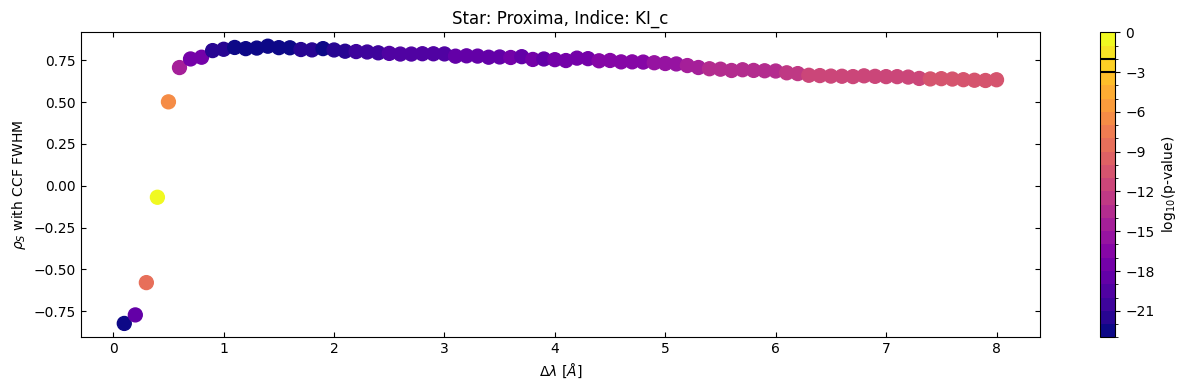

In [13]:
def correlation_bandpass_plot(star, indice):

    df_correlations = pd.read_csv(f"tutorial_results_1d_full/{star}/{indice}/correlations_{star}_{indice}.csv")

    cmap = plt.get_cmap("plasma")
    log_pval_min, log_pval_max = 0, -23
    
    boundaries = np.arange(log_pval_max, log_pval_min + 1, 1)  # Intervals of 1
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(13, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")
    sc1 = axes.scatter(df_correlations["bandpass"], df_correlations["rho_fwhm"], c=np.log10(df_correlations["pval_fwhm"]), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]")
    axes.set_ylabel(r"$\rho_S$ with CCF FWHM")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(p-value)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    correlation_bandpass_plot(star, ind)

plt.show()